# Cleaning

## Import Data Frames

In [ ]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")   
import matplotlib.pyplot as plt

zf = zipfile.ZipFile('SystemAccessLog_Start_Merged.csv.zip')
original_df = pd.read_csv(zf.open('SystemAccessLog_Start_Merged.csv'))

/Users/mayaghai/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# term_dates = pd.read_excel('DARO_term1_w_end_date.xlsx')

## Define Functions

In [ ]:
def check_group_consistency(dataframe: pd.DataFrame, group_by_col: str, check_col: str) -> pd.Series:
    """
    Checks for consistency within groups for a specific column.

    Calculates the number of unique values in 'check_col' for each group
    defined by 'group_by_col'. Returns a Series containing only those
    groups that have more than one unique value in 'check_col'.

    Args:
        dataframe: The pandas DataFrame to analyze.
        group_by_col: The name of the column to group the DataFrame by.
        check_col: The name of the column whose unique values within
                   each group should be counted.

    Returns:
        A pandas Series indexed by the unique values of 'group_by_col',
        showing the count (>1) of unique values in 'check_col' for
        groups that are inconsistent. Returns an empty Series if all
        groups are consistent for the checked column.

    Raises:
        KeyError: If group_by_col or check_col are not in the DataFrame's columns.
    """
    if group_by_col not in dataframe.columns:
        raise KeyError(f"Grouping column '{group_by_col}' not found in DataFrame.")
    if check_col not in dataframe.columns:
        raise KeyError(f"Checking column '{check_col}' not found in DataFrame.")

    # Group by the specified column and count unique values in the target column
    value_counts_per_group = dataframe.groupby(group_by_col)[check_col].nunique()

    # Filter to find groups with more than one unique value
    inconsistent_groups = value_counts_per_group[value_counts_per_group > 1]

    return inconsistent_groups

## Data Pre-Processing and Cleaning

In [ ]:
original_df.head()

,SessionId,Timestamp,Device,new_id,Session Time,AGE_GROUP_LONG_NAME,GENDER,ADMIT_TERM_CODE,APPL_STATUS_IN_CA_NAME,CURRENT_STAY_STATUS,PRIMARY_PROGRAM_CODE,SUCCESS_LEVEL,ACADEMIC_PERFORMANCE,term_end_date
0,122836922,2022-01-31,NaN,3c57943d195b8827,13:28:37.067Z,26 to 30,M,2022-01-01,Study Permit (student visa),Graduated - On Time,3825.0,Successful,AB - Good,2022-04-11
1,122836922,2022-01-31,NaN,3c57943d195b8827,15:39:16.723Z,26 to 30,M,2022-01-01,Study Permit (student visa),Graduated - On Time,3825.0,Successful,AB - Good,2022-04-11
2,122836922,2022-01-31,NaN,3c57943d195b8827,16:26:53.267Z,26 to 30,M,2022-01-01,Study Permit (student visa),Graduated - On Time,3825.0,Successful,AB - Good,2022-04-11
3,122836926,2022-01-31,NaN,43d2b11ec4c1a36e,13:28:38.187Z,26 to 30,F,2022-01-01,Study Permit (student visa),Graduated - On Time,1607.0,Successful,AB - Good,2022-04-11
4,122836926,2022-01-31,NaN,43d2b11ec4c1a36e,15:34:57.107Z,26 to 30,F,2022-01-01,Study Permit (student visa),Graduated - On Time,1607.0,Successful,AB - Good,2022-04-11


In [ ]:
original_df.drop('Device',axis=1,inplace=True, errors='ignore') 

In [ ]:
df = original_df.copy()

In [ ]:
df['SessionId'] = df['SessionId'].astype(str)

In [ ]:
print("\nMissing Value Percentage per Column:")
print((df.isnull().sum() / len(df)) * 100)


Missing Value Percentage per Column:
SessionId                 0.000000
Timestamp                 0.000000
new_id                    0.000000
Session Time              0.000000
AGE_GROUP_LONG_NAME       1.125323
GENDER                    0.116676
ADMIT_TERM_CODE           0.000000
APPL_STATUS_IN_CA_NAME    1.125323
CURRENT_STAY_STATUS       0.000000
PRIMARY_PROGRAM_CODE      0.000000
SUCCESS_LEVEL             0.000000
ACADEMIC_PERFORMANCE      0.000000
term_end_date             0.000000
dtype: float64


In [ ]:
grouping_column = 'new_id'
column_to_check = 'ADMIT_TERM_CODE'

try:
    inconsistent_users = check_group_consistency(df, grouping_column, column_to_check)

    if not inconsistent_users.empty:
        print(f"'{grouping_column}' groups with more than one unique '{column_to_check}':")
        print(inconsistent_users)
    else:
        print(f"All '{grouping_column}' groups have a consistent '{column_to_check}'.")

except KeyError as e:
    print(f"Error: {e}")


'new_id' groups with more than one unique 'ADMIT_TERM_CODE':
new_id
003783fd936e5732    2
00bd23043142d0bf    2
00bfabd80ccd5ff2    2
00f419f65fffed5f    2
011f2b20e6581c60    2
                   ..
feb2581e4bbc5844    2
ff00d57e08dc525d    2
ff19fb22fa9b7ebc    2
ff3d6da65dfd3392    2
ffe9e357f3b82d20    2
Name: ADMIT_TERM_CODE, Length: 1392, dtype: int64


In [ ]:
def handle_duplicate_admit_term_code(df):
    """
    Modifies 'new_id' for users with multiple unique 'ADMIT_TERM_CODE' values.
    
    For users with multiple ADMIT_TERM_CODEs, appends '_2', '_3', etc.
    to the 'new_id' for later ADMIT_TERM_CODEs.

    If multiple rows have the same ADMIT_TERM_CODE for a user, they share the same new_id.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The modified DataFrame.
    """
    df = df.copy()  # Don't modify original

    new_ids = []

    for name, group in df.groupby('new_id', sort=False):
        # Sort within group by ADMIT_TERM_CODE
        group_sorted = group.sort_values('ADMIT_TERM_CODE')

        # Track unique admit terms and assign suffix
        admit_terms = group_sorted['ADMIT_TERM_CODE'].unique()

        if len(admit_terms) > 1:
            # More than one admit term
            for i, term in enumerate(admit_terms):
                suffix = f"_{i+1}" if i > 0 else ""
                idxs = group_sorted[group_sorted['ADMIT_TERM_CODE'] == term].index
                for idx in idxs:
                    new_ids.append((idx, f"{name}{suffix}"))
        else:
            # Only one admit term → keep name
            for idx in group_sorted.index:
                new_ids.append((idx, name))

    # Assign new IDs
    new_id_map = dict(new_ids)
    df['new_id'] = df.index.map(new_id_map)

    return df


df = handle_duplicate_admit_term_code(df)

In [ ]:
grouping_column = 'new_id'
column_to_check = 'ADMIT_TERM_CODE'

try:
    inconsistent_users = check_group_consistency(df, grouping_column, column_to_check)

    if not inconsistent_users.empty:
        print(f"'{grouping_column}' groups with more than one unique '{column_to_check}':")
        print(inconsistent_users)
    else:
        print(f"All '{grouping_column}' groups have a consistent '{column_to_check}'.")

except KeyError as e:
    print(f"Error: {e}")


All 'new_id' groups have a consistent 'ADMIT_TERM_CODE'.


In [ ]:
def consolidate_success_level(group):
    if ('Successful' in group.values) or ('In progress' in group.values):
        return 'Successful'
    elif ('Unsuccessful' in group.values) or ('In Progress' in group.values):
        return 'Unsuccessful'

df['SUCCESS_LEVEL'] = df.groupby(grouping_column)['SUCCESS_LEVEL'].transform(consolidate_success_level)



In [ ]:
COLUMN_TO_CONVERT = ['Timestamp', 'term_end_date']

# Check if the column exists and convert
for column in COLUMN_TO_CONVERT:
    if column in df.columns:
        df[column] = pd.to_datetime(df[column], errors='coerce')
        print(f"Converted '{column}' to datetime.")
    else:
        print(f"Column '{column}' not found in DataFrame.")

Converted 'Timestamp' to datetime.
Converted 'term_end_date' to datetime.


In [ ]:

print("Starting aggregation...")

# --- Prepare Data ---
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['activity_date'] = df['Timestamp'].dt.normalize()

# --- Active Days ---
active_days = df.groupby('new_id')['activity_date'].nunique().rename('unique_active_days')

# --- Daily & Weekly Variance ---
daily_counts = df.groupby(['new_id', 'activity_date']).size().rename('daily_log_count').reset_index()
daily_var = daily_counts.groupby('new_id')['daily_log_count'].var().rename('daily_log_variance').fillna(0)

weekly_counts = df.groupby(['new_id', pd.Grouper(key='activity_date', freq='W-MON')]).size().rename('weekly_log_count').reset_index()
weekly_var = weekly_counts.groupby('new_id')['weekly_log_count'].var().rename('weekly_log_variance').fillna(0)

variability_features = pd.concat([daily_var, weekly_var], axis=1)

# --- Longest Consecutive Active Days ---
def longest_streak(dates):
    dates = sorted(set(dates))
    streak = max_streak = 1 if dates else 0
    for i in range(1, len(dates)):
        streak = streak + 1 if (dates[i] - dates[i-1]).days == 1 else 1
        max_streak = max(max_streak, streak)
    return max_streak

consecutive_days = df.groupby('new_id')['activity_date'].apply(longest_streak).rename('longest_consecutive_active_days')

# --- Rolling Average Trend Slope ---
def compute_rolling_trend(group):
    if len(group) < 14:
        return np.nan
    rolling_avg = group['daily_log_count'].rolling(window=7, min_periods=1).mean().dropna()
    if len(rolling_avg) < 2:
        return np.nan
    x = np.arange(len(rolling_avg)).reshape(-1, 1)
    y = rolling_avg.values
    model = LinearRegression()
    model.fit(x, y)
    return model.coef_[0]

rolling_trends = (
    daily_counts
    .sort_values(['new_id', 'activity_date'])
    .groupby('new_id')
    .apply(compute_rolling_trend)
    .rename('rolling_avg_trend_slope')
)

# --- Log Deviation from Program Average ---
user_logs = df.groupby(['new_id', 'PRIMARY_PROGRAM_CODE']).size().rename('user_log_count').reset_index()
program_avg = user_logs.groupby('PRIMARY_PROGRAM_CODE')['user_log_count'].mean().rename('program_avg_logs').reset_index()
log_dev = (
    user_logs.merge(program_avg, on='PRIMARY_PROGRAM_CODE')
    .assign(log_deviation_from_program=lambda x: x['user_log_count'] - x['program_avg_logs'])
    .set_index('new_id')['log_deviation_from_program']
)

# --- Rolling Daily Average ---
rolling_avg_7d = (
    daily_counts
    .sort_values(['new_id', 'activity_date'])
    .groupby('new_id')['daily_log_count']
    .transform(lambda x: x.rolling(7, min_periods=1).mean())
)

avg_rolling_7d = daily_counts.assign(rolling_avg_7d=rolling_avg_7d).groupby('new_id')['rolling_avg_7d'].mean().rename('rolling_7d_avg_logs')

# --- Main Aggregation ---
agg_map = {
    'SUCCESS_LEVEL': 'last',
    'AGE_GROUP_LONG_NAME': 'first',
    'GENDER': 'first',
    'ADMIT_TERM_CODE': 'first',
    'APPL_STATUS_IN_CA_NAME': 'first',
    'CURRENT_STAY_STATUS': 'last',
    'PRIMARY_PROGRAM_CODE': 'first',
    'ACADEMIC_PERFORMANCE': 'first',
    'SessionId': 'count',
    'Timestamp': ['min', 'max']
}

df_user = df.groupby('new_id').agg(agg_map)
df_user.columns = ['_'.join(filter(None, col)).strip('_') for col in df_user.columns]

# --- Join Engineered Features ---
df_user = df_user.join([
    active_days,
    log_dev,
    avg_rolling_7d,
    variability_features,
    consecutive_days,
    rolling_trends
])

# --- Final Feature: Session Span ---
df_user['session_span_days'] = (df_user['Timestamp_max'] - df_user['Timestamp_min']).dt.total_seconds() / (60*60*24)

print("Aggregation completed.")
df_user.info()


Starting aggregation...
Aggregation completed.
<class 'pandas.core.frame.DataFrame'>
Index: 38494 entries, 0000cf80a3f3206a to fffdecaa52500c60
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   SUCCESS_LEVEL_last               38494 non-null  object        
 1   AGE_GROUP_LONG_NAME_first        38056 non-null  object        
 2   GENDER_first                     38429 non-null  object        
 3   ADMIT_TERM_CODE_first            38494 non-null  object        
 4   APPL_STATUS_IN_CA_NAME_first     38056 non-null  object        
 5   CURRENT_STAY_STATUS_last         38494 non-null  object        
 6   PRIMARY_PROGRAM_CODE_first       38494 non-null  float64       
 7   ACADEMIC_PERFORMANCE_first       38494 non-null  object        
 8   SessionId_count                  38494 non-null  int64         
 9   Timestamp_min                    38494 non-null  datetime64

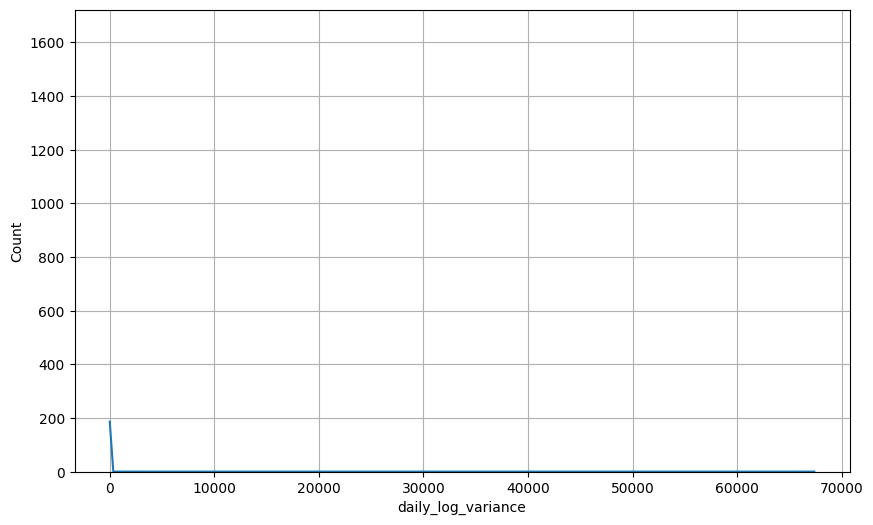

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_user['daily_log_variance'], kde=True)
plt.grid(True)
plt.show()

In [ ]:
# Map Ordinal Categories
df_user['AGE_GROUP_LONG_NAME_first'].unique()

array(['36 to 40', '0 to 18', '31 to 35', '26 to 30', '21 to 25',
       '41 to 50', '19 to 20', '51 to 60', None, '66+', '61 to 65'],
      dtype=object)

In [ ]:
df_user['ACADEMIC_PERFORMANCE_first'].unique()

array(['AB - Good', 'DF - Poor', 'C - Satisfactory', 'ZZ - Unknown'],
      dtype=object)

In [ ]:
import numpy as np

# Define the ordinal encodings in a dictionary of format:
# {column_name: ([ordered_categories], new_column_name)}
ordinal_encodings = {
    'AGE_GROUP_LONG_NAME_first': (
        ['0 to 18', '19 to 20', '21 to 25', '26 to 30', '31 to 35',
         '36 to 40', '41 to 50', '51 to 60', '61 to 65', '66+'],
        'AGE_GROUP_ordinal'
    ),
    'ACADEMIC_PERFORMANCE_first': (
        ['DF - Poor', 'C - Satisfactory', 'AB - Good'],
        'ACADEMIC_PERFORMANCE_ordinal'
    )
}

for col, (ordered_values, new_col) in ordinal_encodings.items():
    if col in df_user.columns:
        # Create mapping
        mapping = {k: i for i, k in enumerate(ordered_values)}
        if col == 'ACADEMIC_PERFORMANCE_first':
            mapping['ZZ - Unknown'] = np.nan  # Handle special case

        # Apply and create new column
        df_user[new_col] = df_user[col].map(mapping)
        df_user.drop(columns=col, inplace=True)  # Drop original string column

        # Log results
        print(f"Encoded '{col}' → '{new_col}'")
        print(df_user[new_col].value_counts(dropna=False).sort_index())
    else:
        print(f"Column '{col}' not found.")


Encoded 'AGE_GROUP_LONG_NAME_first' → 'AGE_GROUP_ordinal'
AGE_GROUP_ordinal
0.0     4316
1.0     6905
2.0    12173
3.0     6881
4.0     3245
5.0     2198
6.0     1944
7.0      351
8.0       32
9.0       11
NaN      438
Name: count, dtype: int64
Encoded 'ACADEMIC_PERFORMANCE_first' → 'ACADEMIC_PERFORMANCE_ordinal'
ACADEMIC_PERFORMANCE_ordinal
0.0     5262
1.0     8139
2.0    24568
NaN      525
Name: count, dtype: int64


In [ ]:
df_user.reset_index()

,new_id,SUCCESS_LEVEL_last,GENDER_first,ADMIT_TERM_CODE_first,APPL_STATUS_IN_CA_NAME_first,CURRENT_STAY_STATUS_last,PRIMARY_PROGRAM_CODE_first,SessionId_count,Timestamp_min,Timestamp_max,unique_active_days,log_deviation_from_program,rolling_7d_avg_logs,daily_log_variance,weekly_log_variance,longest_consecutive_active_days,rolling_avg_trend_slope,session_span_days,AGE_GROUP_ordinal,ACADEMIC_PERFORMANCE_ordinal
0,0000cf80a3f3206a,Successful,F,2022-09-01,Study Permit (student visa),Graduated - On Time,1207.0,524,2022-09-01,2022-12-10,93,63.506024,5.558474,11.017064,171.495238,41,0.028198,100.0,5.0,2.0
1,00024c40cef486cc,Unsuccessful,M,2022-09-01,Canadian Citizen,Left College - Enrolled 2 Terms,3703.0,157,2022-09-06,2022-12-10,59,-182.703704,2.735997,4.676213,33.873626,7,-0.006229,95.0,0.0,0.0
2,0002d2ebd89ea8cd,Successful,M,2022-09-01,Study Permit (student visa),Graduated - On Time,3776.0,437,2022-09-06,2022-12-10,92,-142.180328,4.655797,5.793956,56.335165,33,0.024245,95.0,4.0,2.0
3,000698ff5c581e09,Successful,F,2022-09-01,Study Permit (student visa),Graduated - On Time,2890.0,302,2022-09-01,2022-12-10,84,-55.629032,3.532313,7.906483,108.980952,35,0.015935,100.0,3.0,2.0
4,000915a44be41906,Unsuccessful,F,2022-09-01,Study Permit (student visa),Stepped Out - 2 Terms Away,3109.0,431,2022-09-06,2022-12-10,82,105.938462,5.345064,11.155827,148.027473,21,-0.011169,95.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38489,ffed705b05a2a6fa,Successful,F,2022-09-01,Study Permit (student visa),Graduated - On Time,2870.0,330,2022-09-06,2022-12-10,80,-15.627803,4.080536,8.642405,69.032967,24,-0.023751,95.0,3.0,2.0
38490,fff05347678bc430,Unsuccessful,F,2023-05-01,Study Permit (student visa),Stepped Out - 1 Term Away,1824.0,370,2023-05-06,2023-08-09,80,-90.864553,4.723601,13.553797,175.952381,19,-0.004960,95.0,1.0,1.0
38491,fff0860d19afbee5,Successful,F,2023-09-01,Study Permit (student visa),Graduated - On Time,2860.0,817,2023-09-01,2023-12-10,99,322.110778,8.113757,17.190682,337.980952,97,-0.002001,100.0,2.0,2.0
38492,fffd021c310b2e45,Successful,F,2022-05-01,Study Permit (student visa),Graduated - On Time,2805.0,215,2022-05-12,2022-08-09,69,-237.703797,3.061456,5.721654,81.478022,10,0.002678,89.0,1.0,1.0


In [ ]:
# Fill missing values in 'APPL_STATUS_IN_CA_NAME_first' with 'Unknown'
df_user.fillna({'APPL_STATUS_IN_CA_NAME_first': 'Unknown'}, inplace=True)

print(df_user['APPL_STATUS_IN_CA_NAME_first'].isnull().sum())

0


In [ ]:
categorical_cols = ['SUCCESS_LEVEL_last','ADMIT_TERM_CODE_first','PRIMARY_PROGRAM_CODE_first', 'GENDER_first', 'APPL_STATUS_IN_CA_NAME_first', 'CURRENT_STAY_STATUS_last','session_span_days']
for col in categorical_cols:
    print(f"\nValue Counts for {col}:")
    print(df_user[col].value_counts(normalize=False))
    print(f"Missing in {col}: {df_user[col].isnull().sum()}")


Value Counts for SUCCESS_LEVEL_last:
SUCCESS_LEVEL_last
Unsuccessful    19439
Successful      19055
Name: count, dtype: int64
Missing in SUCCESS_LEVEL_last: 0

Value Counts for ADMIT_TERM_CODE_first:
ADMIT_TERM_CODE_first
2022-09-01    10721
2023-09-01     9517
2023-01-01     7504
2022-01-01     5220
2023-05-01     2968
2022-05-01     2555
2021-09-01        8
2021-05-01        1
Name: count, dtype: int64
Missing in ADMIT_TERM_CODE_first: 0

Value Counts for PRIMARY_PROGRAM_CODE_first:
PRIMARY_PROGRAM_CODE_first
2528.0    1011
2860.0     711
2803.0     682
2825.0     639
3408.0     620
          ... 
3435.0       1
2821.0       1
3459.0       1
8122.0       1
2864.0       1
Name: count, Length: 284, dtype: int64
Missing in PRIMARY_PROGRAM_CODE_first: 0

Value Counts for GENDER_first:
GENDER_first
F    19388
M    18975
N       66
Name: count, dtype: int64
Missing in GENDER_first: 65

Value Counts for APPL_STATUS_IN_CA_NAME_first:
APPL_STATUS_IN_CA_NAME_first
Study Permit (student visa) 

In [ ]:
df_user = df_user.reset_index()

## Visualizations

In [ ]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38494 entries, 0 to 38493
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   new_id                           38494 non-null  object        
 1   SUCCESS_LEVEL_last               38494 non-null  object        
 2   GENDER_first                     38429 non-null  object        
 3   ADMIT_TERM_CODE_first            38494 non-null  object        
 4   APPL_STATUS_IN_CA_NAME_first     38494 non-null  object        
 5   CURRENT_STAY_STATUS_last         38494 non-null  object        
 6   PRIMARY_PROGRAM_CODE_first       38494 non-null  float64       
 7   SessionId_count                  38494 non-null  int64         
 8   Timestamp_min                    38494 non-null  datetime64[ns]
 9   Timestamp_max                    38494 non-null  datetime64[ns]
 10  unique_active_days               38494 non-null  int64    

In [ ]:
# Fill NaN with a string (e.g., 'Missing')
for col in categorical_cols:
    df_user[col] = df_user[col].fillna('Unknown')

# Or, remove rows with NaN in the categorical columns
# df_user = df_user.dropna(subset=categorical_cols)

Starting EDA visualizations...


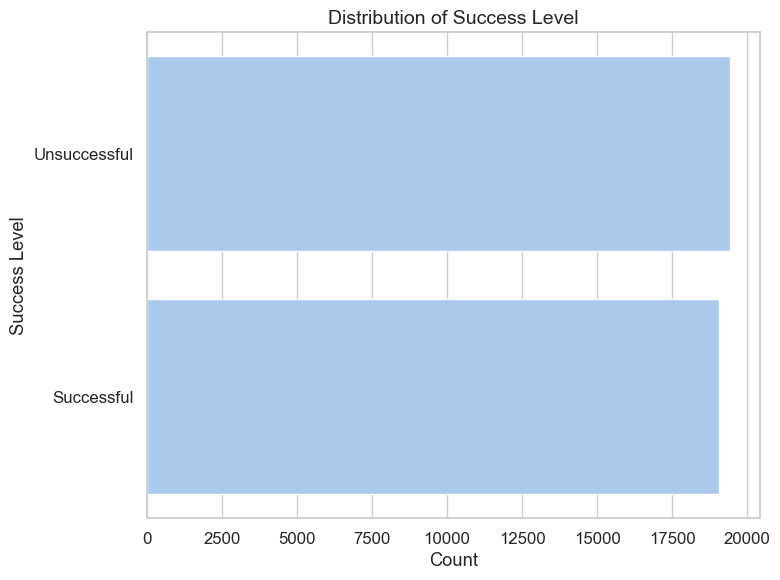

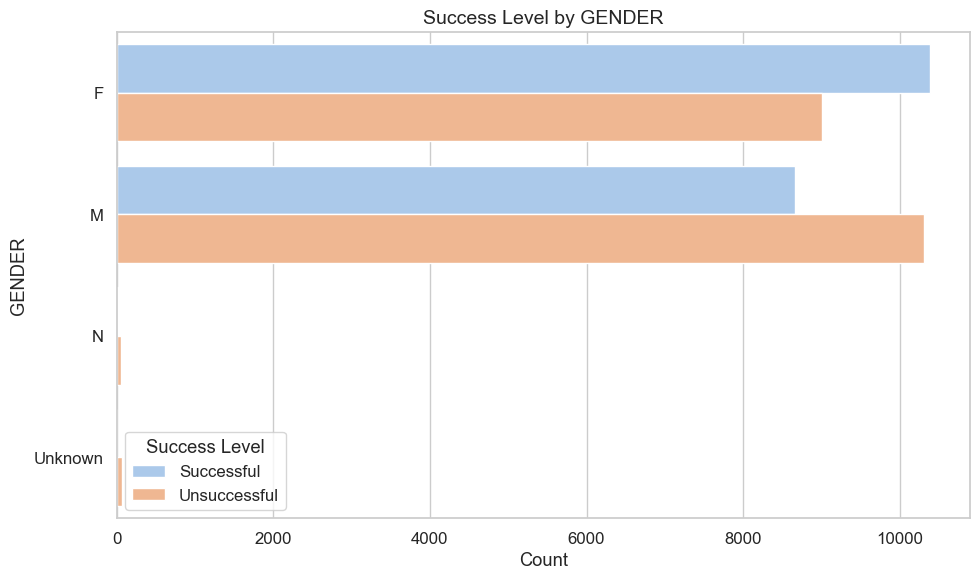

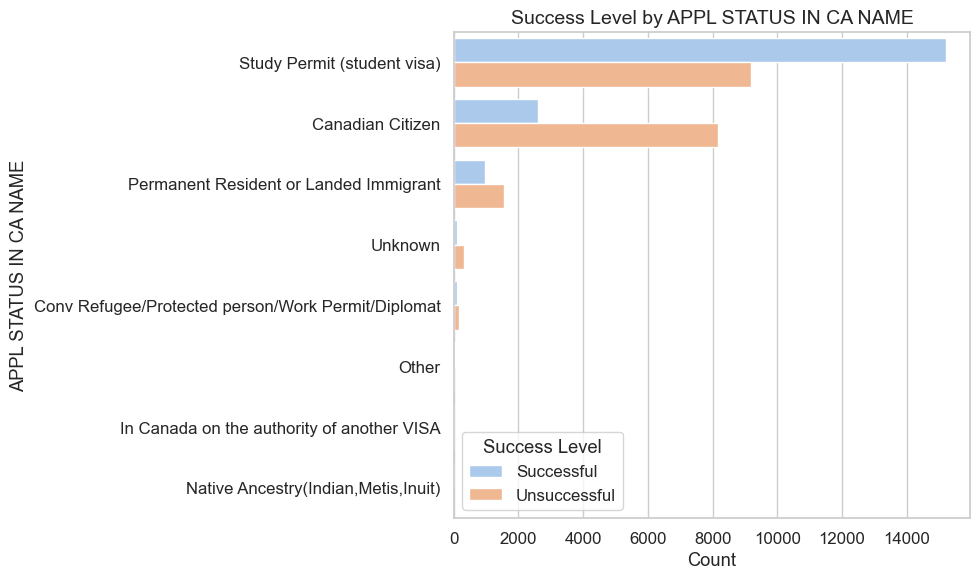

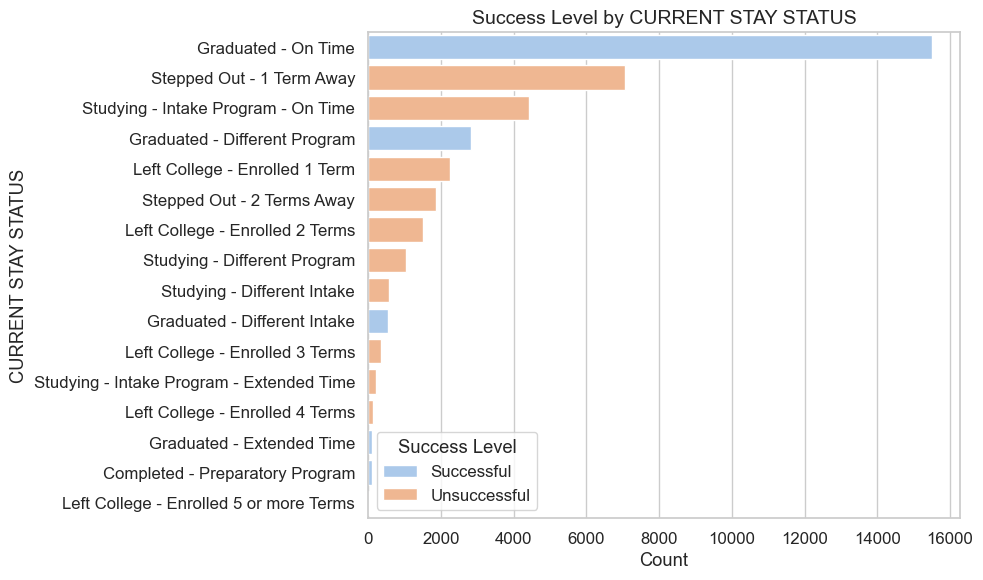

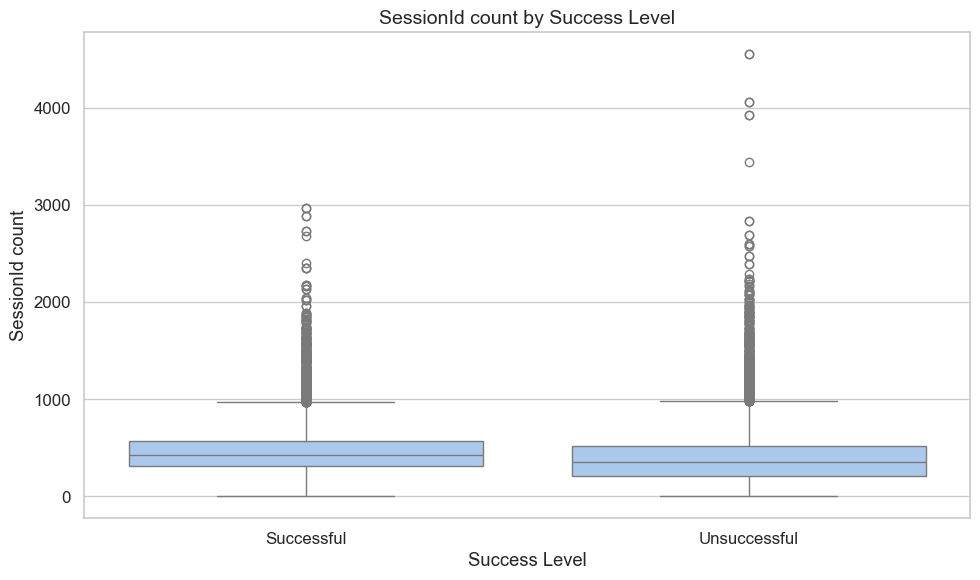

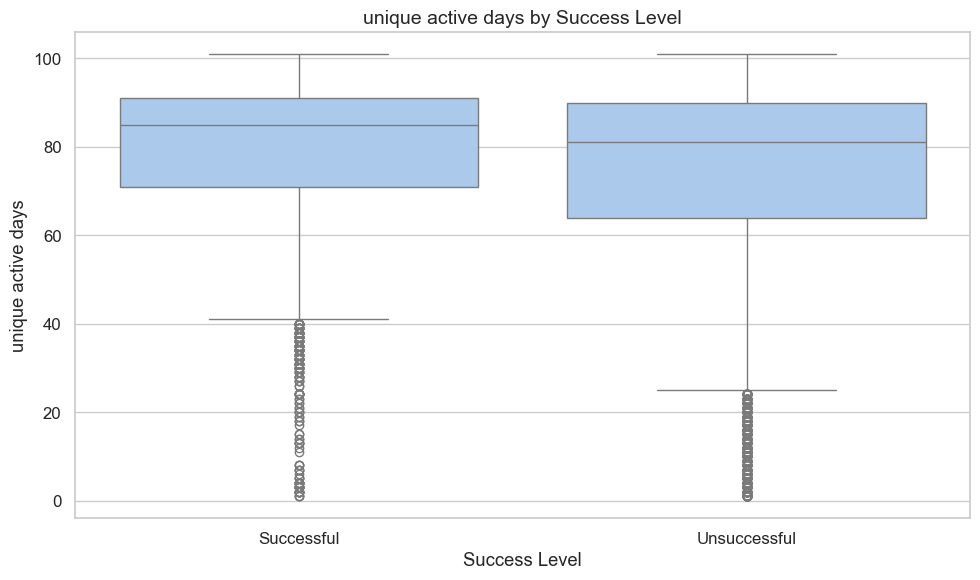

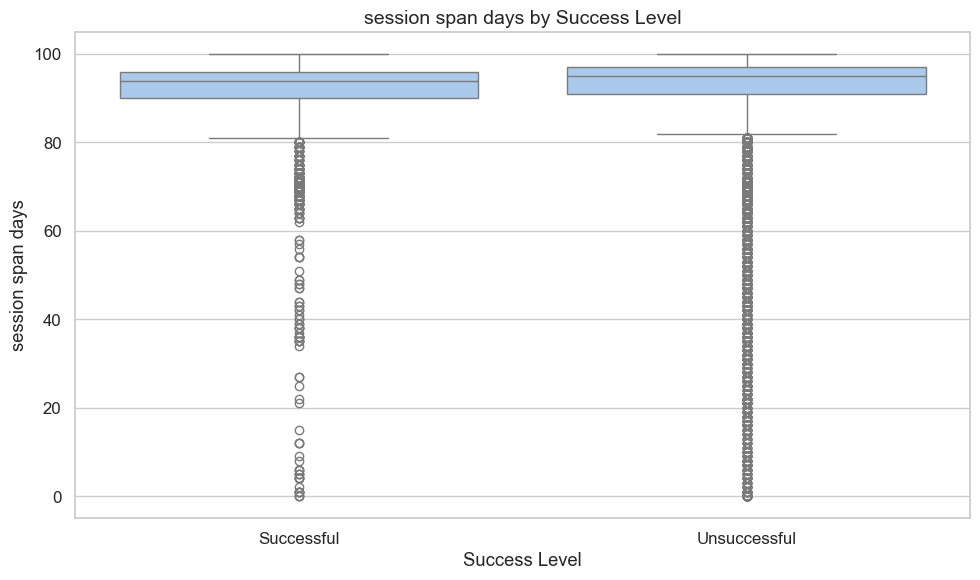

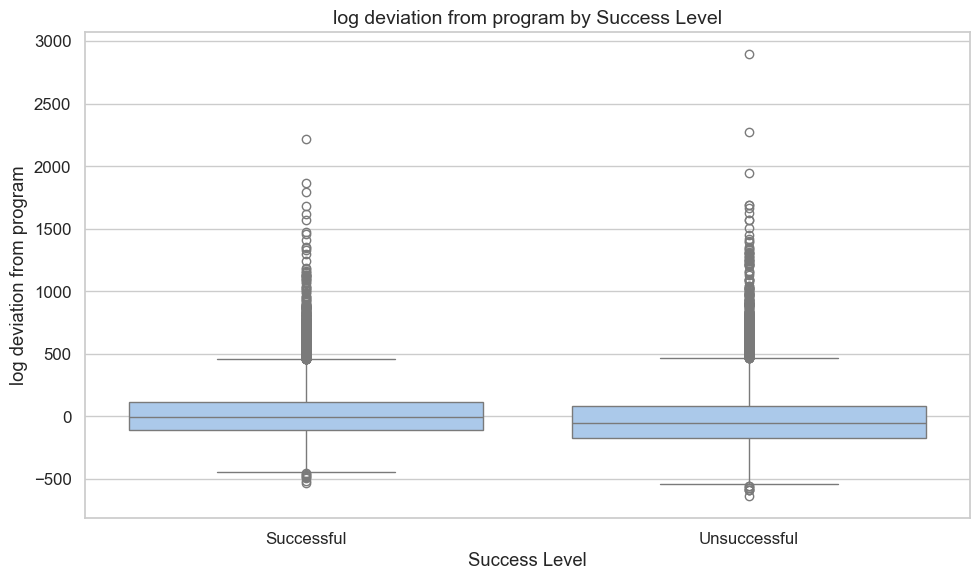

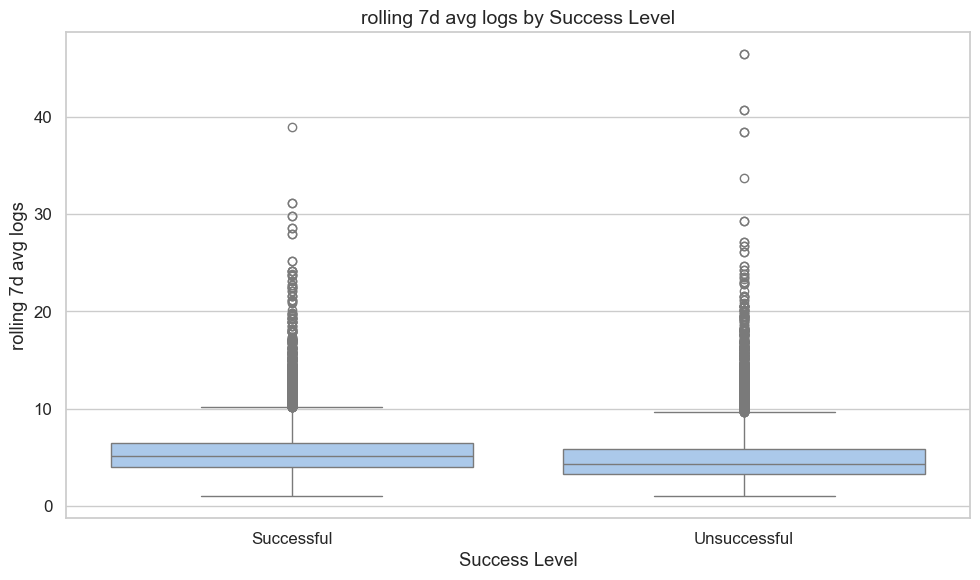

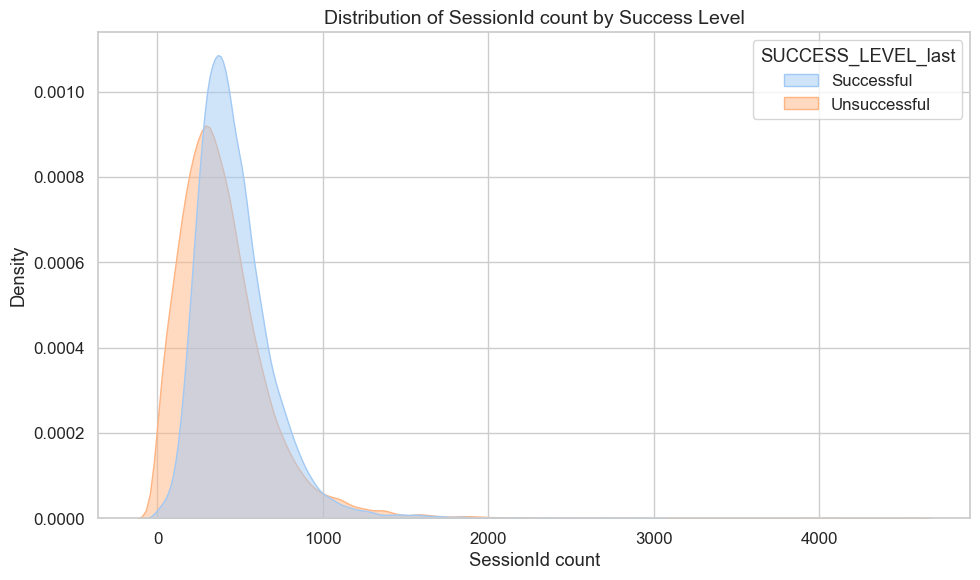

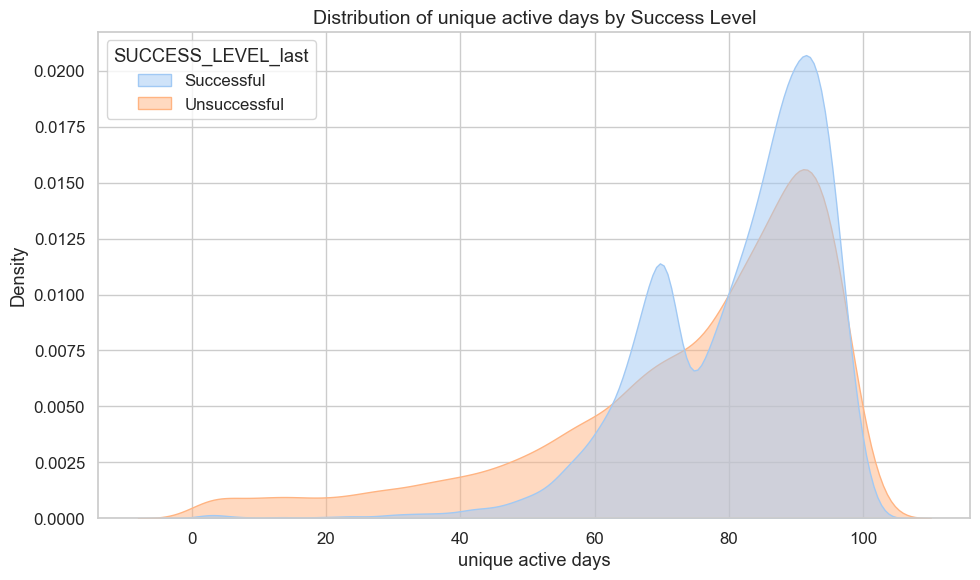

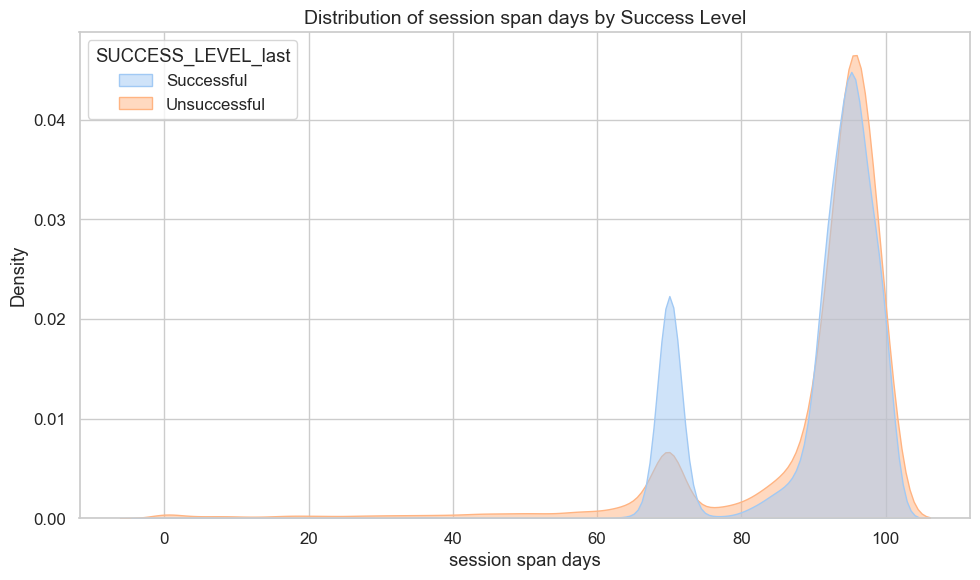

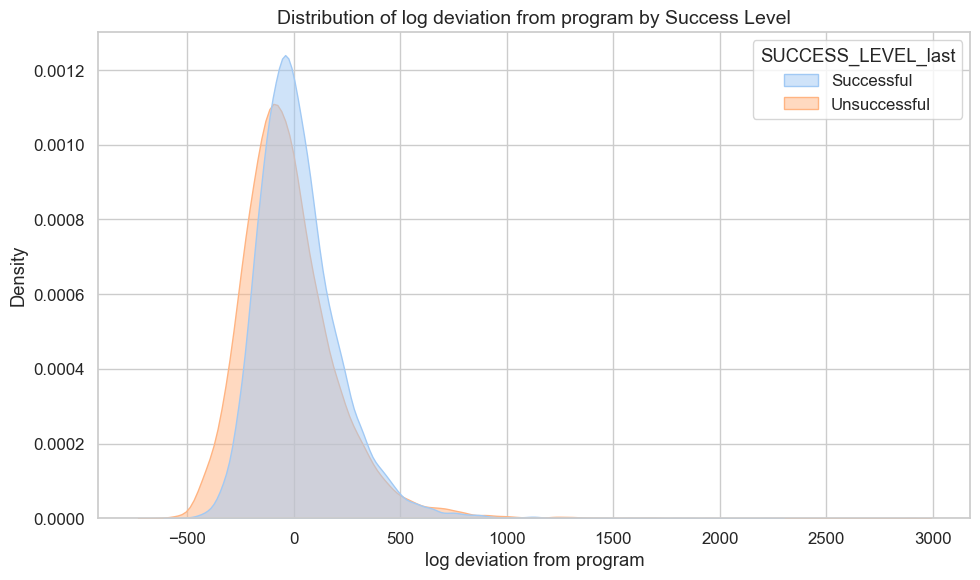

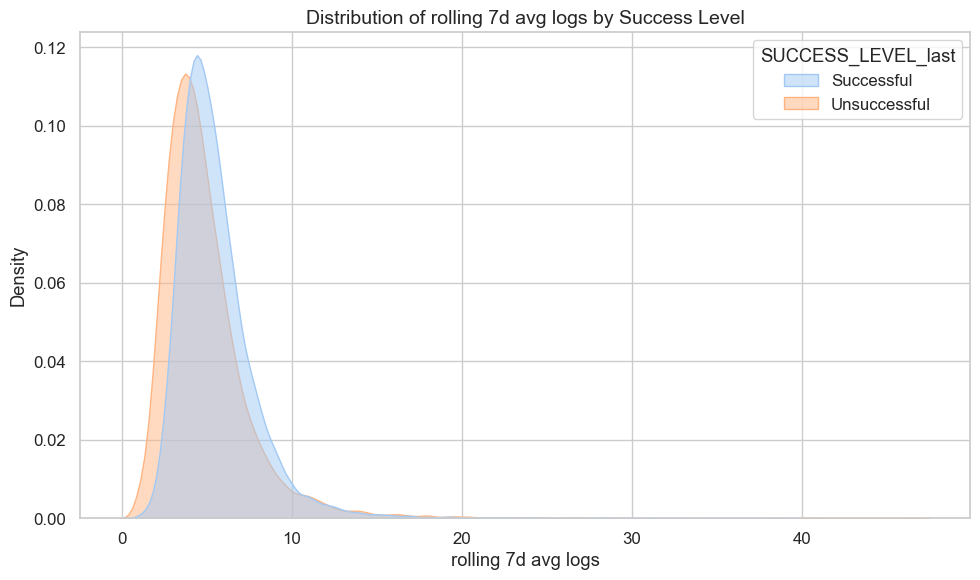

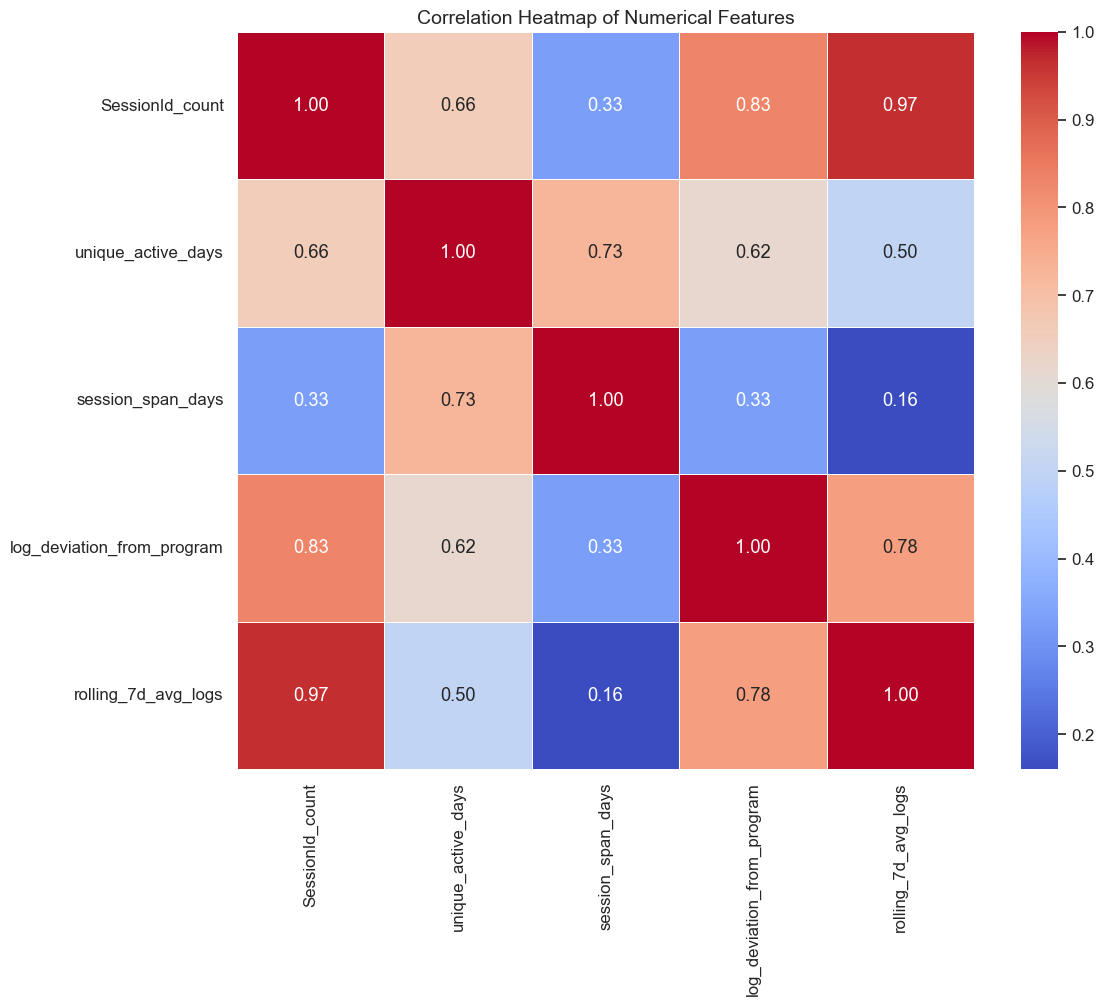

In [ ]:
sns.set_theme(style='whitegrid', palette='pastel', font_scale=1.1)

print("Starting EDA visualizations...")

# --- Target Variable Distribution ---
plt.figure(figsize=(8, 6))
sns.countplot(data=df_user, y='SUCCESS_LEVEL_last', order=df_user['SUCCESS_LEVEL_last'].value_counts().index.unique())
plt.title('Distribution of Success Level', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Success Level')
plt.tight_layout()
plt.show()

# --- Categorical Predictors vs. Success Level ---
categorical_cols = ['GENDER_first', 'APPL_STATUS_IN_CA_NAME_first',
                    'CURRENT_STAY_STATUS_last']

for col in categorical_cols:
    value_counts_index = df_user[col].value_counts().index
    # Ensure the index for ordering is unique
    unique_index = value_counts_index.unique()

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_user, y=col, hue='SUCCESS_LEVEL_last', order=unique_index)
    plt.title(f'Success Level by {col.replace("_first", "").replace("_last", "").replace("_", " ").strip()}', fontsize=14)
    plt.xlabel('Count')
    plt.ylabel(col.replace("_first", "").replace("_last", "").replace("_", " ").strip())
    plt.legend(title='Success Level')
    plt.tight_layout()
    plt.show()

# --- Numerical Predictors vs. Success Level (Box Plots) ---
numerical_cols = ['SessionId_count', 'unique_active_days', 'session_span_days',
                 'log_deviation_from_program',
                  'rolling_7d_avg_logs']

for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='SUCCESS_LEVEL_last', y=col, data=df_user)
    plt.title(f'{col.replace("_", " ")} by Success Level', fontsize=14)
    plt.xlabel('Success Level')
    plt.ylabel(col.replace("_", " "))
    plt.tight_layout()
    plt.show()

# --- Numerical Predictors vs. Success Level (Distribution Plots - KDE) ---
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df_user, x=col, hue='SUCCESS_LEVEL_last', fill=True, alpha=.5)
    plt.title(f'Distribution of {col.replace("_", " ")} by Success Level', fontsize=14)
    plt.xlabel(col.replace("_", " "))
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

# --- Correlation Heatmap of Numerical Features ---
numerical_cols_for_corr = ['SessionId_count', 'unique_active_days', 'session_span_days',
                        'log_deviation_from_program',
                           'rolling_7d_avg_logs']
plt.figure(figsize=(12, 10))
corr_matrix = df_user[numerical_cols_for_corr].corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, square=True)
plt.title('Correlation Heatmap of Numerical Features', fontsize=14)
plt.tight_layout()
plt.show()

# Modelling

In [ ]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38494 entries, 0 to 38493
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   new_id                           38494 non-null  object        
 1   SUCCESS_LEVEL_last               38494 non-null  object        
 2   GENDER_first                     38494 non-null  object        
 3   ADMIT_TERM_CODE_first            38494 non-null  object        
 4   APPL_STATUS_IN_CA_NAME_first     38494 non-null  object        
 5   CURRENT_STAY_STATUS_last         38494 non-null  object        
 6   PRIMARY_PROGRAM_CODE_first       38494 non-null  float64       
 7   SessionId_count                  38494 non-null  int64         
 8   Timestamp_min                    38494 non-null  datetime64[ns]
 9   Timestamp_max                    38494 non-null  datetime64[ns]
 10  unique_active_days               38494 non-null  int64    

In [ ]:
df_model = df_user.copy()
df_model = df_model[df_model['SUCCESS_LEVEL_last'] != 'In Progress'].copy()
df_model['SUCCESS_STATUS'] = df_model['SUCCESS_LEVEL_last'] == 'Successful'
df_model.drop('SUCCESS_LEVEL_last',axis=1,inplace=True)


In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38494 entries, 0 to 38493
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   new_id                           38494 non-null  object        
 1   GENDER_first                     38494 non-null  object        
 2   ADMIT_TERM_CODE_first            38494 non-null  object        
 3   APPL_STATUS_IN_CA_NAME_first     38494 non-null  object        
 4   CURRENT_STAY_STATUS_last         38494 non-null  object        
 5   PRIMARY_PROGRAM_CODE_first       38494 non-null  float64       
 6   SessionId_count                  38494 non-null  int64         
 7   Timestamp_min                    38494 non-null  datetime64[ns]
 8   Timestamp_max                    38494 non-null  datetime64[ns]
 9   unique_active_days               38494 non-null  int64         
 10  log_deviation_from_program       38494 non-null  float64  

In [ ]:

# Set 'new_id' as index for easier tracking
df_model = df_model.set_index('new_id')

# Fill any remaining NA values in the entire dataset 
df_model = df_model.fillna(0)

# Set Primary Program Code as categorical
df_model['PRIMARY_PROGRAM_CODE_first'] = df_model['PRIMARY_PROGRAM_CODE_first'].astype('category')

# Define features and target
columns_to_drop = [
    'ADMIT_TERM_CODE_first',
    'session_span_days',
    'AGE_GROUP_ordinal',
    'SUCCESS_STATUS',         # Target variable
    'Timestamp_min',          # Drop time-related columns
    'Timestamp_max',
    'CURRENT_STAY_STATUS_last',  # Drop columns with categorical data that shouldn't be in features
    'APPL_STATUS_IN_CA_NAME_first',
    'ACADEMIC_PERFORMANCE_ordinal',
    'GENDER_first',            # 
]

# Feature matrix (X) and target vector (y)
X = df_model.drop(columns=columns_to_drop)
y = df_model['SUCCESS_STATUS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [ ]:

warnings.filterwarnings("ignore")
# --- 2. Define hyperparameter grid ---
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1],
}

# --- 3. Set up scorer ---
f1_scorer = make_scorer(f1_score, average='weighted')

# --- 4. Stratified K-Fold setup ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 5. Define base XGBoost model ---
base_model = XGBClassifier(
    enable_categorical=True,
    eval_metric='logloss',
    booster='gbtree',
    use_label_encoder=True,
    random_state=42,
    n_jobs=-1
)

# --- 6. Grid search with cross-validation ---
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=0,
    error_score='raise'
)

# --- 7. Train the model ---
grid_search.fit(X_train, y_train)

# --- 8. Make predictions ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# --- 9. Report best results ---
print("\n Best Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   - {param}: {value}")
print(f"\n Best Weighted F1 Score (CV): {grid_search.best_score_:.4f}")

# --- 10. Evaluate on test set ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))

# --- 11. Predict probabilities for later use ---
y_pred_proba = best_model.predict_proba(X_test)


/Users/mayaghai/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [18:06:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mayaghai/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [18:06:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mayaghai/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [18:06:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mayaghai/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [18:06:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.


 Best Hyperparameters:
   - colsample_bytree: 0.8
   - gamma: 0.1
   - learning_rate: 0.05
   - max_depth: 5
   - n_estimators: 200
   - subsample: 0.8

 Best Weighted F1 Score (CV): 0.7758

Classification Report:
              precision    recall  f1-score   support

       False     0.7725    0.7965    0.7843      4860
        True     0.7856    0.7607    0.7730      4764

    accuracy                         0.7788      9624
   macro avg     0.7791    0.7786    0.7786      9624
weighted avg     0.7790    0.7788    0.7787      9624


Confusion Matrix:
      0     1
0  3871   989
1  1140  3624


In [ ]:
X_train.head()

,PRIMARY_PROGRAM_CODE_first,SessionId_count,unique_active_days,log_deviation_from_program,rolling_7d_avg_logs,daily_log_variance,weekly_log_variance,longest_consecutive_active_days,rolling_avg_trend_slope
new_id,,,,,,,,,
01fd7f03efedb66b,5850.0,646,93,42.196000,6.723400,19.638382,406.923810,45,0.010003
03a04d3f0913f1c1,1811.0,399,86,-44.832487,4.695044,9.480301,79.192308,30,-0.018155
05b61af0c5be08b0,6616.0,262,80,-1.828326,3.324494,3.037342,36.681319,11,-0.017154
3644ac37f667134e,1824.0,298,66,-162.864553,4.463456,12.899767,171.910256,13,-0.020069
482a2b63010b55dd,1823.0,487,72,-42.884848,6.579134,20.267410,207.218182,68,0.029346


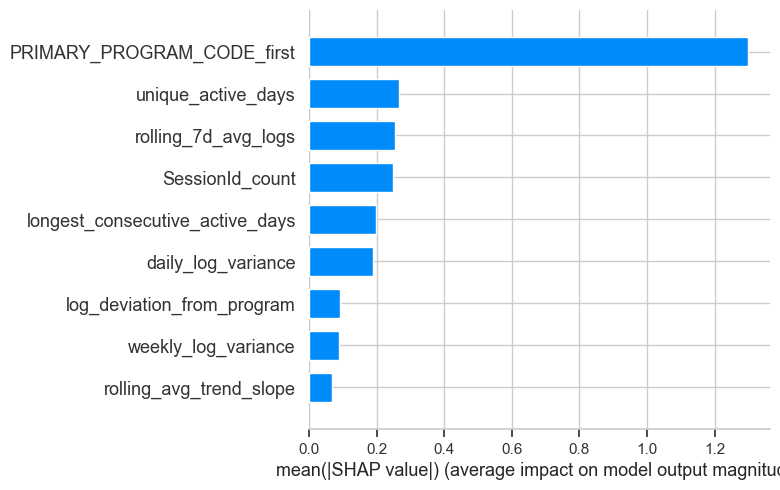

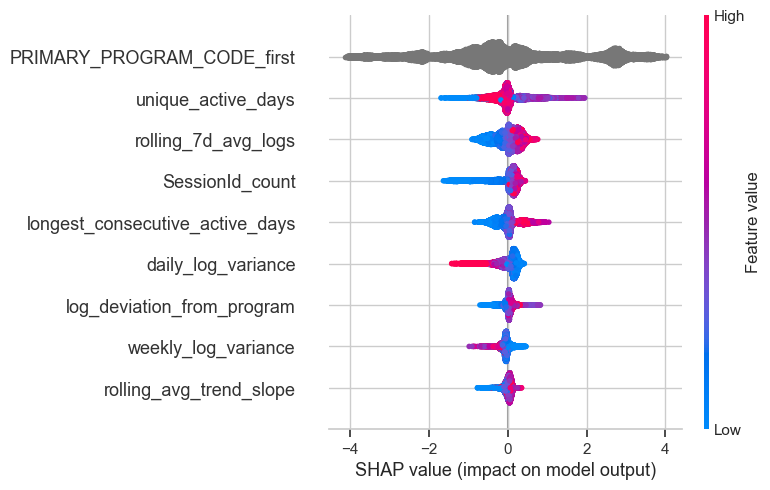

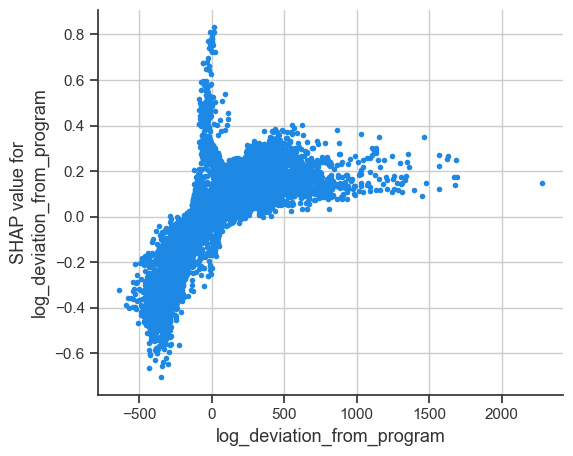

In [ ]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=10)
shap.summary_plot(shap_values, X_train, max_display=10)
shap.dependence_plot("log_deviation_from_program", shap_values.values, X_train, interaction_index=None)